In [2]:
import os
import pyspark.mllib
import numpy as np
import matplotlib.pyplot
import seaborn as sns
import pyspark
import urllib
import pandas as pd

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from IPython.display import display, HTML
sns.set_style('whitegrid')
%matplotlib inline

get_ipython().magic(u'pylab inline')

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rand', 'cbrt', 'rank', 'cosh', 'hypot', 'tan', 'array', 'size', 'isnan', 'randn', 'log', 'floor', 'sum', 'sqrt', 'degrees', 'split', 'rint', 'log10', 'sin', 'repeat', 'log2', 'cos', 'ceil', 'broadcast', 'sinh', 'trunc', 'expm1', 'tanh', 'radians', 'exp', 'log1p', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


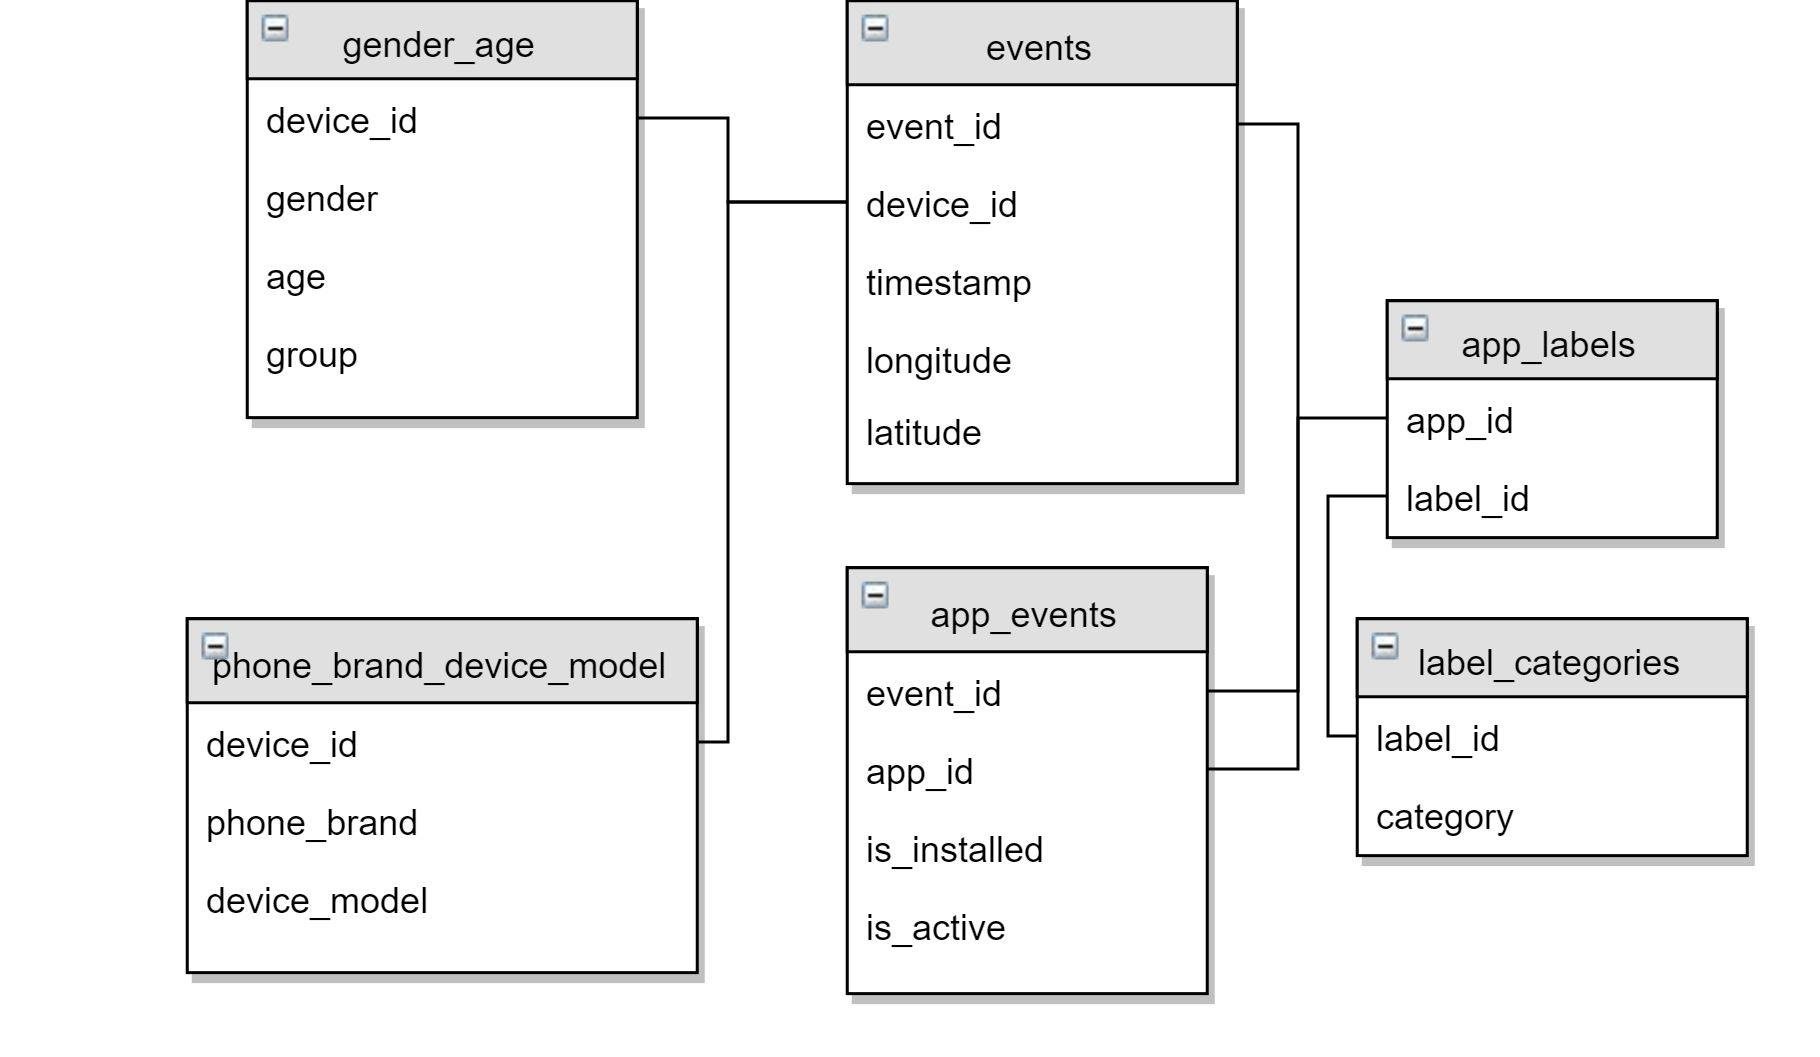

In [4]:
from IPython.display import Image
Image(filename='RelationalDatabasesFlow.jpg')

# Metrics
1. Most Active Apps
2. Most Installed Apps
3. Most Installed and Active Apps
4. apps_per_device_count
5. apps_per_event_avg
6. apps_active_per_device_count
7. apps_active_per_event_avg
8. categories_per_device_count 
9. app_per_device_count 
10. categories_per_app_avg

In [3]:
### Initialize streaming context
conf = SparkConf()\
                .setMaster("local[2]")\
                .setAppName("MobileAnalyticsEDAAppUsage")\
                .set("spark.executor.memory", "6g")\
                .set("spark.driver.memory", "6g")
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
sqlContext = SQLContext(sc)
spark = SparkSession.builder.appName("spark play").getOrCreate()

# Data Gathering

In [4]:
phone_brand_model_csv = "data/phone_brand_device_model_key.csv"
gender_age_train_csv = "data/gender_age_train.csv"
gender_age_test_csv = "data/gender_age_test.csv"
events_csv = "data/events.csv"
app_events_csv = "data/app_events.csv"
app_labels_csv ="data/app_labels.csv"
label_categories_csv = "data/label_categories.csv"

train_CSV ="data/train"
test_CSV ="data/test"

# Exploratory Data Analysis

## App Events

In [7]:
app_events = spark.read.csv(app_events_csv, header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8").persist()
app_events.show()

+--------+--------------------+------------+---------+
|event_id|              app_id|is_installed|is_active|
+--------+--------------------+------------+---------+
|       2| 5927333115845830913|           1|        1|
|       2|-5720078949152207372|           1|        0|
|       2|-1633887856876571208|           1|        0|
|       2| -653184325010919369|           1|        1|
|       2| 8693964245073640147|           1|        1|
|       2| 4775896950989639373|           1|        1|
|       2|-8022267440849930066|           1|        0|
|       2| 9112463267739110219|           1|        0|
|       2|-3725672010020973973|           1|        0|
|       2| 7167114343576723123|           1|        1|
|       2|  487766649788038994|           1|        0|
|       2| 7460082553072507347|           1|        0|
|       2|  628020936226491308|           1|        0|
|       2|  701031210314548601|           1|        0|
|       2|-1758857579862594461|           1|        0|
|       2|

In [8]:
print "shape:" + str(((app_events.count(), len(app_events.columns))))

shape:(32473067, 4)


In [9]:
print app_events.select("event_id").distinct().count()

1488096


In [10]:
print app_events.select("app_id").distinct().count()

19237


In [11]:
app_events_cleaned = app_events.drop_duplicates()

In [12]:
print "shape:" + str(((app_events_cleaned.count(), len(app_events_cleaned.columns))))

shape:(32473067, 4)


# Most App Installs

In [13]:
app_events_installed = app_events.filter((col("is_installed") == 1)) \
                              .groupby('app_id') \
                              .agg({"is_installed":"sum"})\
                              .rdd.sortBy(lambda x: x[1], ascending=False)\
                              .toDF()\
                              .toPandas()\
                              .set_index("app_id")
app_events_installed

,sum(is_installed)
app_id,
8693964245073640147,1151391
5927333115845830913,898788
4348659952760821294,795995
628020936226491308,620659
3433289601737013244,373186
-2320783822570582843,295619
5729517255058371973,272353
3683147815759994238,265823
6284164581582112235,260639


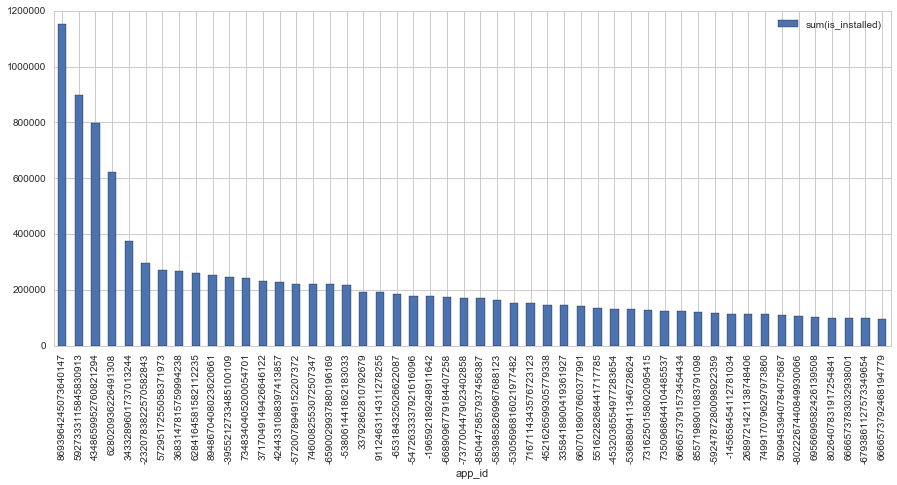

In [14]:
mpl.rcParams['figure.figsize'] = (15.0, 6.0)
app_events_installed[0:50].plot(kind = 'bar')

In [15]:
app_events_installed = app_events.filter((col("is_installed") == 1)) \
                              .groupby('app_id') \
                              .agg({"is_installed":"sum"})\
                              .rdd.sortBy(lambda x: x[1], ascending=False)\
                              .toDF()\
                              .toPandas()
app_events_installed

,app_id,sum(is_installed)
0,8693964245073640147,1151391
1,5927333115845830913,898788
2,4348659952760821294,795995
3,628020936226491308,620659
4,3433289601737013244,373186
5,-2320783822570582843,295619
6,5729517255058371973,272353
7,3683147815759994238,265823
8,6284164581582112235,260639
9,8948670408023620661,254316


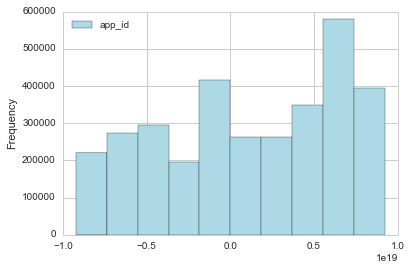

In [22]:
app_events_histogram = app_events.filter((col("is_installed") == 1)).select("app_id").sample(False, 0.1).toPandas().plot(kind='hist', bins=10, facecolor='lightblue')

# Most Active Apps

In [65]:
app_events_active = app_events.filter((col("is_active") == 1)) \
                              .groupby('app_id') \
                              .agg({"is_active":"sum"})\
                              .rdd.sortBy(lambda x: x[1], ascending=False)\
                              .toDF()\
                              .toPandas()\
                              .set_index("app_id")
app_events_active

,sum(is_active)
app_id,
8693964245073640147,918156
5927333115845830913,617102
4348659952760821294,427541
3433289601737013244,373186
628020936226491308,349882
6284164581582112235,260639
8948670408023620661,254316
-3955212733485100109,244681
-538061441862183033,215627


# Most Active Apps

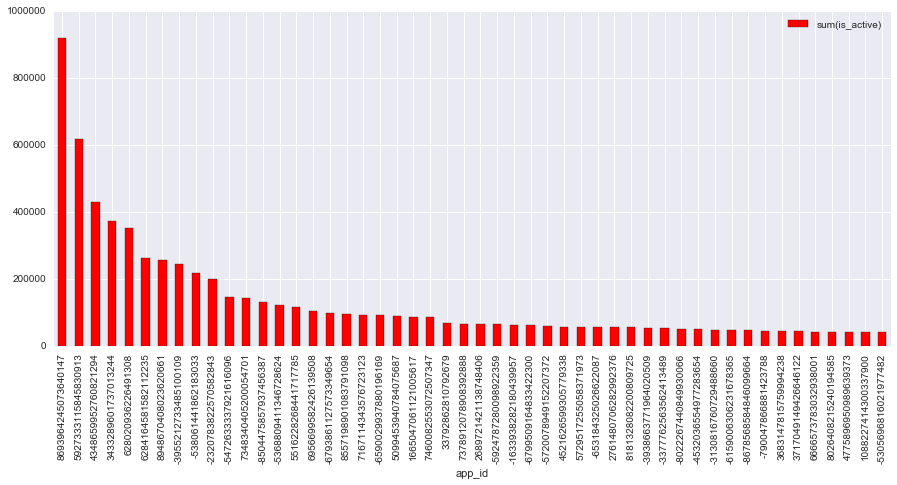

In [92]:
mpl.rcParams['figure.figsize'] = (15.0, 6.0)
app_events_active[0:50].plot(kind = 'bar', color = 'red')

# Most Active Installed Apps

In [61]:
apps_installed_active = app_events.filter((col("is_installed") == 1) & (col("is_active") == 1))\
                                  .groupby('app_id') \
                                  .agg({"is_installed":"sum"})\
                                  .rdd.sortBy(lambda x: x[1], ascending=False)\
                                  .toDF()\
                                  .toPandas()\
                                  .set_index("app_id")
apps_installed_active

,sum(is_installed)
app_id,
8693964245073640147,918156
5927333115845830913,617102
4348659952760821294,427541
3433289601737013244,373186
628020936226491308,349882
6284164581582112235,260639
8948670408023620661,254316
-3955212733485100109,244681
-538061441862183033,215627


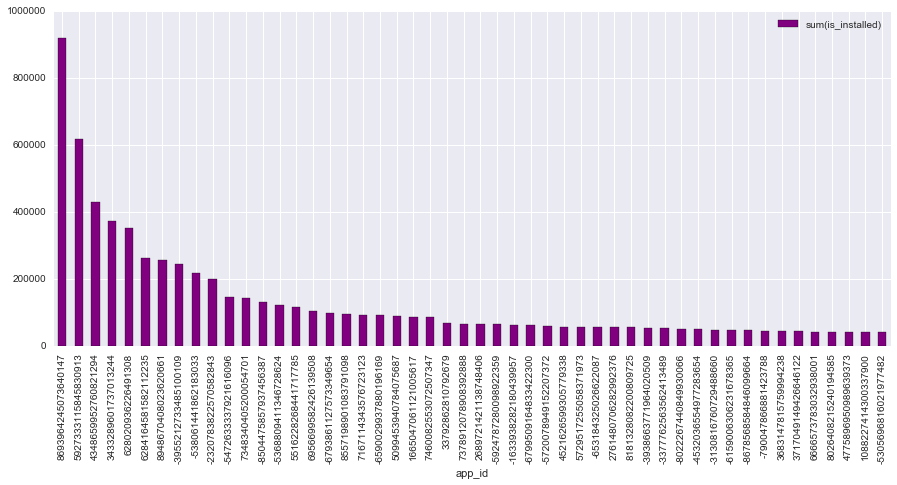

In [91]:
mpl.rcParams['figure.figsize'] = (15.0, 6.0)
apps_installed_active[0:50].plot(kind = 'bar', color = 'purple')

# Explore App Categories 

In [69]:
label_categories = spark.read.csv(label_categories_csv, header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8").persist()
print label_categories.count()
label_categories.show()

930
+--------+--------------------+---------------+
|label_id|            category|label_itunes_id|
+--------+--------------------+---------------+
|       1|                null|             26|
|       2|      game-game type|              8|
|       3|    game-Game themes|              8|
|       4|      game-Art Style|              8|
|       5|   game-Leisure time|              8|
|       6| game-Cutting things|              8|
|       7|  game-Finding fault|              8|
|       8|game-stress reliever|              8|
|       9|            game-pet|              8|
|      10|         game-Answer|              8|
|      11|        game-Fishing|              8|
|      12|game-Music and Dance|              8|
|      13|         game-Puzzle|              8|
|      14|game-Adventure pu...|              8|
|      15| game-Parkour Racing|              8|
|      16|        game-Parkour|              8|
|      17|         game-Racing|              8|
|      18|     game-Motorcycle|     

In [71]:
print "shape:" + str(((label_categories.count(), len(label_categories.columns))))

shape:(930, 3)


In [72]:
print label_categories.select("category").distinct().count()

836


In [74]:
print label_categories.filter(col("category") == "unknown").count()

26


In [82]:
print label_categories.filter(col("category").isNull()).count()

3


# Combining App/Categories Data

In [83]:
app_labels = spark.read.csv(app_labels_csv, header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8").persist()
print app_labels.count()
app_labels.show()

459943
+--------------------+--------+
|              app_id|label_id|
+--------------------+--------+
| 7324884708820027918|     251|
|-4494216993218550286|     251|
| 6058196446775239644|     406|
| 6058196446775239644|     407|
| 8694625920731541625|     406|
| 8694625920731541625|     407|
| 1977658975649789753|     406|
| 1977658975649789753|     407|
| 7311663864768030840|     256|
| 5902120154267999338|     256|
| 2441810024319437760|     256|
| 8378607170315253667|     261|
|-7468212093586159919|     256|
|-6493194103110420302|     253|
| 3089609407449461199|     256|
| 2705437723590691734|     253|
|-1919793861139224050|     256|
| 4955831798976247953|     256|
|-7306728226531308671|     256|
| 1078279648391910971|     256|
+--------------------+--------+
only showing top 20 rows



In [86]:
app_label_categories = app_labels.join(label_categories, "label_id", "left_outer").persist()
print app_label_categories.count()
app_label_categories.show()

459943
+--------+--------------------+---------------+---------------+
|label_id|              app_id|       category|label_itunes_id|
+--------+--------------------+---------------+---------------+
|     251| 7324884708820027918|        Finance|              6|
|     251|-4494216993218550286|        Finance|              6|
|     406| 6058196446775239644|        unknown|             26|
|     407| 6058196446775239644|DS_P2P net loan|              6|
|     406| 8694625920731541625|        unknown|             26|
|     407| 8694625920731541625|DS_P2P net loan|              6|
|     406| 1977658975649789753|        unknown|             26|
|     407| 1977658975649789753|DS_P2P net loan|              6|
|     256| 7311663864768030840|     Securities|              6|
|     256| 5902120154267999338|     Securities|              6|
|     256| 2441810024319437760|     Securities|              6|
|     261| 8378607170315253667| Lottery ticket|              6|
|     256|-7468212093586159919|  

In [88]:
print "shape:" + str(((app_label_categories.count(), len(app_label_categories.columns))))

shape:(459943, 4)


-  First there are 930 different label categories for apps.   This is way to many features to look at for this type of prediction.  
-  Looking at iTunes they roll their categories up to 25 different catagories of apps.
-  Added an unknown category because TalkingData has a bunch of categories that don't map to anything, or are simply marked as "unknown"
-  Going to pain stakingly convert 930 categories to 26 categories manually.
    - New label will be label_itunes_id

### iTunes Categories 
- https://itunes.apple.com/us/genre/ios/id36?mt=8

In [17]:
label_categories = spark.read.csv("data/label_categories.csv", header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8")

In [18]:
label_cats_map = {
    "Books": 1,
    "Business": 2,
    "Catalogs": 3,
    "Education": 4,
    "Entertainment": 5,
    "Finance": 6,
    "Food & Drink": 7,
    "Games": 8,
    "Health & Fitness": 9,
    "Lifestyle": 10,
    "Magazines & Newspapers": 11,
    "Medical": 12,
    "Music": 13,
    "Navigation": 14,
    "News": 15,
    "Photo & Video": 16,
    "Productivity": 17,
    "Reference": 18, 
    "Shopping": 19,
    "Social Networking": 20,
    "Sports": 21,
    "Stickers": 22,
    "Travel": 23,
    "Utilities": 24,
    "Weather": 25,
    "Unknown": 26
}

label_categories_mapping = spark.read.csv("data/label_categories_mapping.csv", header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8")
print label_categories_mapping.show(26)

+---------------+---------------------+
|label_itunes_id|label_itunes_category|
+---------------+---------------------+
|              1|                Books|
|              2|             Business|
|              3|             Catalogs|
|              4|            Education|
|              5|        Entertainment|
|              6|              Finance|
|              7|         Food & Drink|
|              8|                Games|
|              9|     Health & Fitness|
|             10|            Lifestyle|
|             11| Magazines & Newsp...|
|             12|              Medical|
|             13|                Music|
|             14|           Navigation|
|             15|                 News|
|             16|        Photo & Video|
|             17|         Productivity|
|             18|            Reference|
|             19|             Shopping|
|             20|    Social Networking|
|             21|               Sports|
|             22|             Stickers|


In [19]:
label_categories = label_categories.alias('label_categories').join(label_categories_mapping.alias('label_categories_mapping'), "label_itunes_id", "left")
label_categories.drop_duplicates()
label_categories.show()

+---------------+--------+--------------------+---------------------+
|label_itunes_id|label_id|            category|label_itunes_category|
+---------------+--------+--------------------+---------------------+
|             26|       1|                null|              Unknown|
|              8|       2|      game-game type|                Games|
|              8|       3|    game-Game themes|                Games|
|              8|       4|      game-Art Style|                Games|
|              8|       5|   game-Leisure time|                Games|
|              8|       6| game-Cutting things|                Games|
|              8|       7|  game-Finding fault|                Games|
|              8|       8|game-stress reliever|                Games|
|              8|       9|            game-pet|                Games|
|              8|      10|         game-Answer|                Games|
|              8|      11|        game-Fishing|                Games|
|              8|   

In [20]:
app_labels = spark.read.csv("data/app_labels.csv", header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8")
app_labels = app_labels.alias('app_labels').join(label_categories.alias('label_categories'), "label_id", "left")
app_labels.show()

+--------+--------------------+---------------+---------------+---------------------+
|label_id|              app_id|label_itunes_id|       category|label_itunes_category|
+--------+--------------------+---------------+---------------+---------------------+
|     251| 7324884708820027918|              6|        Finance|              Finance|
|     251|-4494216993218550286|              6|        Finance|              Finance|
|     406| 6058196446775239644|             26|        unknown|              Unknown|
|     407| 6058196446775239644|              6|DS_P2P net loan|              Finance|
|     406| 8694625920731541625|             26|        unknown|              Unknown|
|     407| 8694625920731541625|              6|DS_P2P net loan|              Finance|
|     406| 1977658975649789753|             26|        unknown|              Unknown|
|     407| 1977658975649789753|              6|DS_P2P net loan|              Finance|
|     256| 7311663864768030840|              6|     Se

In [21]:
app_cat_itunes_freq = app_labels.groupby("label_itunes_category") \
                         .agg(count(lit(1)) \
                         .alias("category_freq")) \
                         .sort(col("category_freq").desc())
app_cat_itunes_freq.show(100)

+---------------------+-------------+
|label_itunes_category|category_freq|
+---------------------+-------------+
|              Unknown|       139373|
|             Business|       115193|
|                Games|       103213|
|            Utilities|        49645|
|              Finance|        29197|
|            Education|         9829|
|               Travel|         2767|
| Magazines & Newsp...|         2597|
|            Reference|         1883|
|                Books|         1663|
|             Shopping|         1369|
|        Entertainment|          927|
|            Lifestyle|          628|
|     Health & Fitness|          406|
|    Social Networking|          342|
|                 News|          241|
|        Photo & Video|          179|
|                Music|          176|
|           Navigation|          137|
|              Medical|          121|
|         Food & Drink|           47|
|              Weather|           10|
+---------------------+-------------+



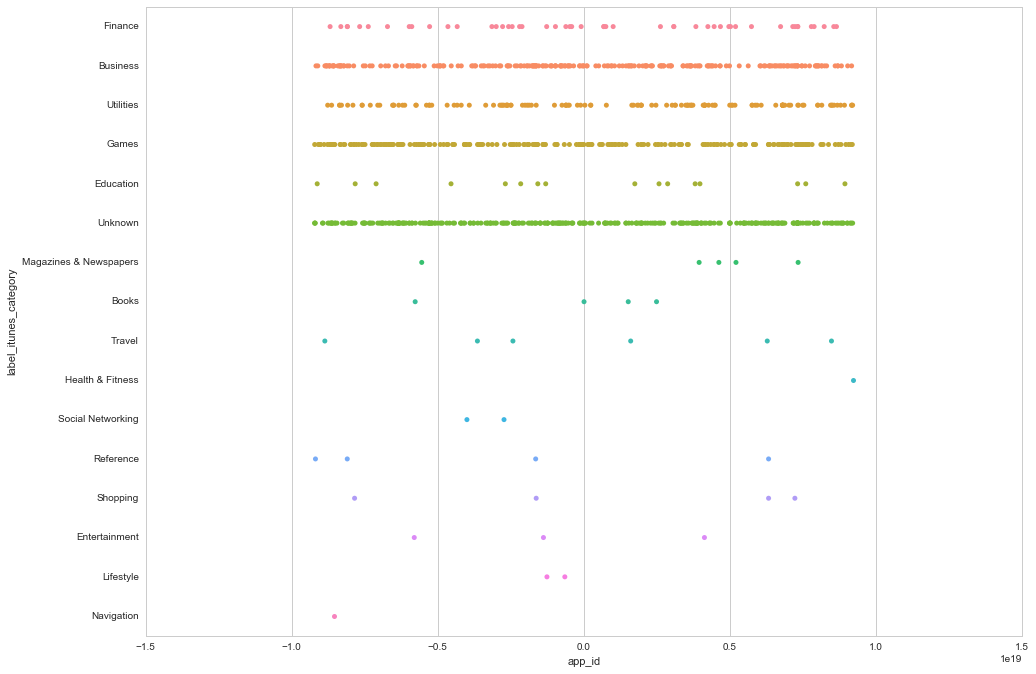

In [22]:
app_labels_pandas = app_labels.toPandas()
app_labels_pandas = app_labels_pandas.sample(1000, replace=True)

a4_dims = (15.7, 11.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.stripplot(x="app_id", y="label_itunes_category", data=app_labels_pandas);

In [25]:
app_cat_freq = app_labels.groupby("category") \
                         .agg(count(lit(1)) \
                         .alias("category_freq")) \
                         .sort(col("category_freq").desc())
app_cat_freq.show(20)

+--------------------+-------------+
|            category|category_freq|
+--------------------+-------------+
|        Industry tag|        56902|
|        Custom label|        53936|
|             Tencent|        49320|
|                game|        48707|
|Property Industry...|        45697|
|              1 free|        19083|
|          Services 1|        11840|
|Property Industry...|         9955|
|         Relatives 1|         9027|
|  Irritation / Fun 1|         8831|
|           Cards RPG|         7375|
|Casual puzzle cat...|         7052|
|Personal Effectiv...|         5910|
|                ARPG|         5306|
|    Chess categories|         5135|
|The elimination o...|         5124|
|      And the Church|         4619|
|               round|         3608|
|             unknown|         2754|
|                free|         2744|
+--------------------+-------------+
only showing top 20 rows



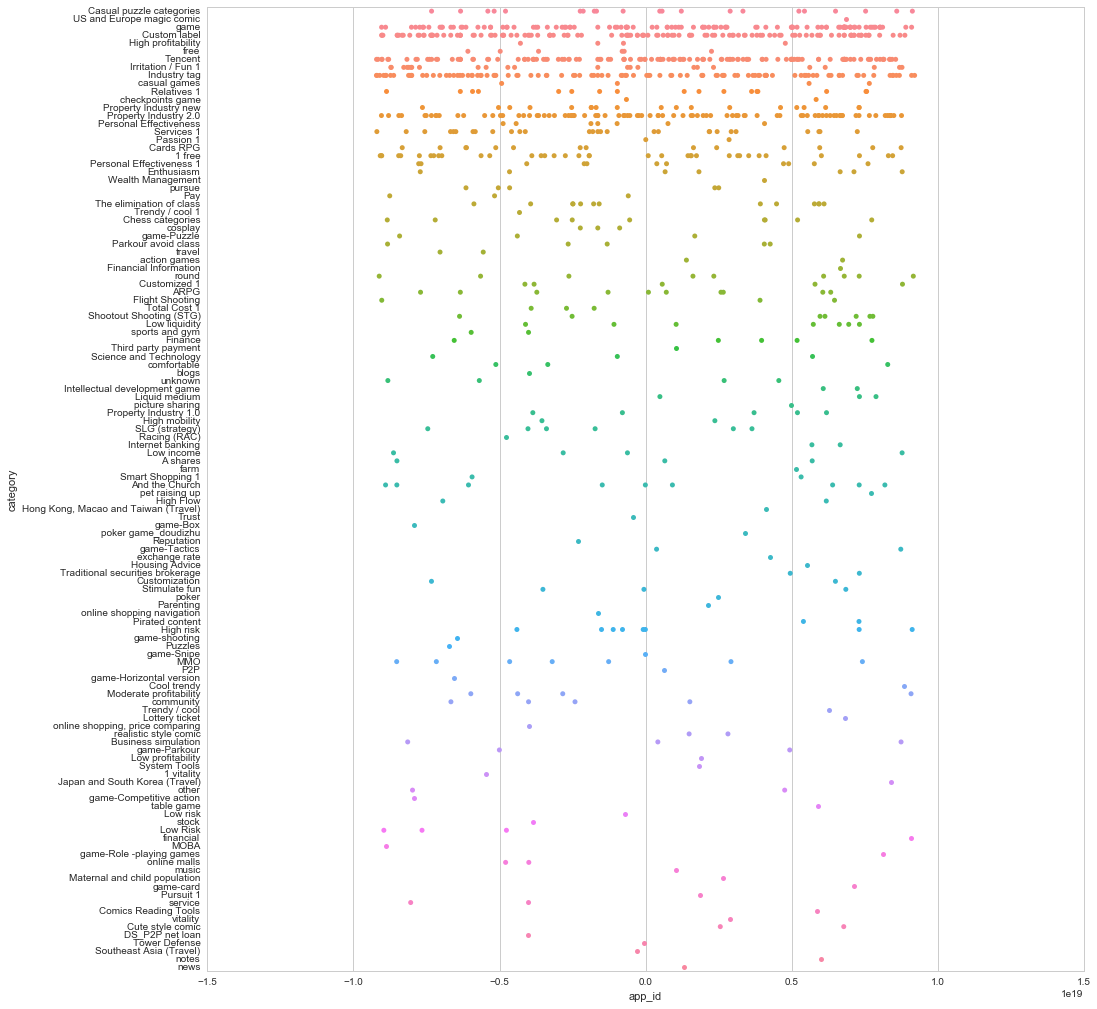

In [24]:
# sns.countplot(x="label_itunes_category", data=label_categories, palette="Greens_d");
app_labels_pandas = app_labels.toPandas()
app_labels_pandas = app_labels_pandas.sample(1000, replace=True)

a4_dims = (15.7, 17.27)
# df = mylib.load_data()
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.stripplot(x="app_id", y="category", data=app_labels_pandas);

# Gender And Age Data 

In [5]:
gender_age_train = spark.read.csv(gender_age_train_csv, header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8").persist()
print gender_age_train.count() 
gender_age_train.show() 

74645
+--------------------+------+---+------+
|           device_id|gender|age| group|
+--------------------+------+---+------+
|-8076087639492063270|     M| 35|M32-38|
|-2897161552818060146|     M| 35|M32-38|
|-8260683887967679142|     M| 35|M32-38|
|-4938849341048082022|     M| 30|M29-31|
|  245133531816851882|     M| 30|M29-31|
|-1297074871525174196|     F| 24|F24-26|
|  236877999787307864|     M| 36|M32-38|
|-8098239495777311881|     M| 38|M32-38|
|  176515041953473526|     M| 33|M32-38|
| 1596610250680140042|     F| 36|F33-42|
| 9032155484127182494|     M| 31|M29-31|
| 7477216237379271436|     F| 37|F33-42|
| 2478205222798310601|     F| 28|F27-28|
| 6352067998666467520|     M| 32|M32-38|
|-7605360767281960867|     M| 48|  M39+|
| 1508636020748379883|     F| 28|F27-28|
| 4380872794486415327|     M| 38|M32-38|
|-1039701474753771322|     M| 38|M32-38|
|-6876541075223249434|     M| 75|  M39+|
| 6287938418661076759|     M| 33|M32-38|
+--------------------+------+---+------+
only showi

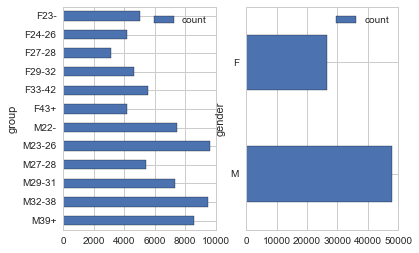

In [6]:
fig, axs = plt.subplots(1,2)
gender_age_train.groupby("group").count().rdd.sortBy(lambda x: x[0], ascending=False).toDF().toPandas().set_index(["group"]).plot(ax=axs[0], kind='barh')
gender_age_train.groupby("gender").count().rdd.sortBy(lambda x: x[0], ascending=False).toDF().toPandas().set_index(["gender"]).plot(ax=axs[1], kind='barh')

# Next Steps
- Convert mobile app plots to Histograms
    - http://blog.madhukaraphatak.com/statistical-data-exploration-spark-part-2/
- Look into Geospatial Data